In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torchvision import transforms, models, datasets
import numpy as np
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import os
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import cv2

In [2]:
from collections import OrderedDict

In [3]:
import timm

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
labels_csv = {'train': "/media/brats/DRIVE1/akansh/Vin-ChestXR-Abnormality-detection/Data/Processed/image_labels_train.csv",
             'test': "/media/brats/DRIVE1/akansh/Vin-ChestXR-Abnormality-detection/Data/Processed/image_labels_test.csv"
             }

data_dir = {'train': "/media/brats/mirlproject2/vinbigdata-chest-xray-abnormalities-detection/vinbig_png/",
           'test': "/media/brats/mirlproject2/vinbigdata-chest-xray-abnormalities-detection/test_png/"}

In [7]:
#Normalization values:
global_labels = ['Pleural effusion', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']

In [63]:
#dataset
class Vin_big_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transforms, data_type = 'train'):
        global_labels = ['Pleural effusion', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
        
        if data_type == 'train':
            label_df = pd.read_csv(label_loc)
            label_df['labels'] = label_df['image_id'] +'_'+ label_df['rad_id']
            label_df.set_index("labels", inplace = True)
            filenames = label_df.index.values.tolist()
            
            self.full_filenames = [os.path.join(image_loc, i.split('_')[0]+'.png') for i in filenames]
            self.labels = []
            for i in tqdm(filenames):
                self.labels.append(label_df[global_labels].loc[i].values.tolist())         
            self.labels = torch.tensor(self.labels)
        if data_type == 'test':                     
            filenames = os.listdir(image_loc)
            self.full_filenames = [os.path.join(image_loc, i) for i in filenames]
            label_df = pd.read_csv(label_loc)
            label_df.set_index("image_id", inplace = True)
            self.labels = [label_df[global_labels].loc[filename[:-4]].values for filename in filenames]
            
        self.transforms = transforms
#         self.data_type = data_type
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = np.array(image, dtype = 'uint8')
        image = self.transforms(image)
        
        return image, self.labels[idx]
    
            

### Get mean and STD

In [64]:
# train_data = Vin_big_dataset(image_loc = data_dir['train'],
#                           label_loc = labels_csv['train'],
#                           transforms = transforms.ToTensor(),
#                           data_type = 'train')

# def get_mean_std(loader):
#     channels_sum, channels_squared_sum, num_batches = 0,0,0
    
#     for data,_ in tqdm(loader):
#         channels_sum += torch.mean(data, dim = [0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim = [0,2,3])
#         num_batches += 1
        
#     mean = channels_sum/num_batches
#     std = (channels_squared_sum/num_batches - mean**2)**0.5
    
#     return mean, std

# mean, std = get_mean_std(DataLoader(train_data,batch_size = 16,shuffle = True))
# print(mean, std)

In [65]:
data_transforms = { 
    "train": transforms.Compose([
#         transforms.Resize((256,256)),
#         transforms.CenterCrop((224,224)),
#         transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p = 0.5), 
        transforms.RandomPerspective(distortion_scale=0.3),
        transforms.RandomRotation((-20,20)),
        transforms.ToTensor(),
        transforms.Normalize([0.5490, 0.5490, 0.5490], [0.2684, 0.2684, 0.2684])
    ]),
    
    "test": transforms.Compose([
#         transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5490, 0.5490, 0.5490], [0.2684, 0.2684, 0.2684])        
    ])
    
}

In [32]:
train_data = Vin_big_dataset(image_loc = data_dir['train'],
                          label_loc = labels_csv['train'],
                          transforms = data_transforms['train'],
                          data_type = 'train')

test_data = Vin_big_dataset(image_loc = data_dir['test'],
                          label_loc = labels_csv['test'],
                          transforms = data_transforms['test'],
                          data_type = 'test')

  0%|          | 0/45000 [00:00<?, ?it/s]

In [48]:
img = Image.open("/media/brats/mirlproject2/vinbigdata-chest-xray-abnormalities-detection/vinbig_png/000434271f63a053c4128a0ba6352c7f.png")

In [83]:
transforms.transforms.Normalize([0.5490, 0.5490, 0.5490], [0.2684, 0.2684, 0.2684])(transforms.ToPILImage())(np.array(img))

TypeError: Input tensor should be a torch tensor. Got <class 'torchvision.transforms.transforms.ToPILImage'>.

In [84]:
transforms.transforms.Normalize([0.5490, 0.5490, 0.5490], [0.2684, 0.2684, 0.2684])(transforms.ToPILImage()(np.array(img)))

TypeError: Input tensor should be a torch tensor. Got <class 'PIL.Image.Image'>.

In [88]:
transforms.Normalize([0.5490], [0.2684])(transforms.ToTensor()(np.array(img)/(255*16)))

tensor([[[13.6165, 13.8430, 14.0311,  ..., -0.5999, -0.6172, -0.6592],
         [ 7.6270,  7.6443,  8.1183,  ..., -1.1350, -1.2236, -1.1670],
         [ 4.5943,  4.1304,  5.4052,  ..., -1.3222, -1.3615, -1.2829],
         ...,
         [-1.9477, -1.9678, -1.8902,  ..., -2.0290, -2.0400, -2.0381],
         [-1.9532, -1.9815, -1.9194,  ..., -2.0281, -2.0409, -2.0455],
         [-1.9487, -1.9633, -1.9167,  ..., -2.0208, -2.0372, -2.0345]]],
       dtype=torch.float64)

In [80]:
np.array(img)/(255*16)

array([[4.20367647e+00, 4.26446078e+00, 4.31495098e+00, ...,
        3.87990196e-01, 3.83333333e-01, 3.72058824e-01],
       [2.59607843e+00, 2.60073529e+00, 2.72794118e+00, ...,
        2.44362745e-01, 2.20588235e-01, 2.35784314e-01],
       [1.78210784e+00, 1.65759804e+00, 1.99975490e+00, ...,
        1.94117647e-01, 1.83578431e-01, 2.04656863e-01],
       ...,
       [2.62254902e-02, 2.08333333e-02, 4.16666667e-02, ...,
        4.41176471e-03, 1.47058824e-03, 1.96078431e-03],
       [2.47549020e-02, 1.71568627e-02, 3.38235294e-02, ...,
        4.65686275e-03, 1.22549020e-03, 0.00000000e+00],
       [2.59803922e-02, 2.20588235e-02, 3.45588235e-02, ...,
        6.61764706e-03, 2.20588235e-03, 2.94117647e-03]])

In [33]:
for x,y in train_data:
    print(x.shape)
    print(y)
    break

TypeError: Cannot handle this data type: (1, 1, 3), <f8

In [12]:
trainloader = DataLoader(train_data,batch_size = 4,shuffle = True)
testloader = DataLoader(test_data,batch_size = 4,shuffle = False)

In [13]:
model = models.densenet201(pretrained=False)

In [21]:
# torch.save(model.state_dict(), "/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/imageNet_DenseNet201.pt")

In [22]:
# model.load_state_dict(torch.load("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/tf_efficientnet_b6_aa-80ba17e4.pth"))

<All keys matched successfully>

In [14]:
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1920,512)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(512,6)),
    ('out', nn.Sigmoid()),
]))

In [15]:
#metric
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import precision_score,recall_score, f1_score
# roc_auc_score(y, clf.decision_function(X), average=None)
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro')*100,
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro')*100,
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro')*100,
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro')*100,
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro')*100,
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro')*100,
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples')*100,
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples')*100,
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples')*100,
            }


In [16]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5, verbose= True)
epochs = 40
test_loss_min = np.Inf

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
if torch.cuda.is_available():
    model = model.cuda()

In [20]:
for x,y in trainloader:
    print(x.shape)
    print(y)
    break

ValueError: std evaluated to zero after conversion to torch.int32, leading to division by zero.

In [19]:
train_loss = []
test_loss = []

for epoch in range(0,epochs):
    train_loss = 0.0
    test_loss = 0.0
    model_train_result = []
    train_target = []
    model_test_result = []
    test_target = []
    
    
    model.train()
    for images,labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        ps = model(images)
        
        #for metric computing
        model_train_result.extend(ps.detach().cpu().numpy().tolist())
        train_target.extend(labels.cpu().numpy())
        
        
        loss = criterion(ps,labels.type(torch.float))
        
        optimizer.zero_grad()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    avg_train_loss = train_loss / len(trainloader)
    train_loss.append(avg_train_loss)
    
    train_result = calculate_metrics(np.array(model_train_result), train_target)
    train_auc = roc_auc_score(train_target, np.array(model_train_result), average=None)
    
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            images = images.to(device)
            ps = model(images)
            
            model_test_result.extend(ps.cpu().numpy().tolist())
            test_target.extend(labels.cpu().numpy())
            
            
            loss = criterion(ps,labels.type(torch.float))
            test_loss += loss.item()
            
        avg_test_loss = test_loss / len(testloader)
        test_loss.append(avg_test_loss)
        
        schedular.step(avg_test_loss)

        test_result = calculate_metrics(np.array(model_test_result), test_target)
        test_auc = roc_auc_score(test_target, np.array(model_test_result), average=None)

        
        if avg_test_loss <= test_loss_min:
                    print('testation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(test_loss_min,avg_test_loss))
                    torch.save({
                        'epoch' : i,
                        'model_state_dict' : model.state_dict(),
                        'optimizer_state_dict' : optimizer.state_dict(),
                        'test_loss_min' : avg_test_loss
                    },'DenseNet_size224.pt')
                
    
    
    print(f"Train Loss: {avg_train_loss}")
    
    print("epoch:{:2d} iter:{:3d} Train: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch,0,
                                              train_result['micro/f1'],
                                              train_result['macro/f1'],
                                              train_result['samples/f1']))
    print(f"Train AUC{train_auc}")
    
    
    print(f"Test Loss: {avg_test_loss}")

    print("epoch:{:2d} iter:{:3d} test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch,0,
                                              test_result['micro/f1'],
                                              test_result['macro/f1'],
                                              test_result['samples/f1']))    
    print(f"Test AUC{test_auc}")
    

  0%|          | 0/11250 [00:00<?, ?it/s]

ValueError: std evaluated to zero after conversion to torch.int32, leading to division by zero.

### Results

In [7]:
train_loss_hist = np.load("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/train_loss_hist.npy")
test_loss_hist = np.load("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/test_loss_hist.npy")
train_AUC_hist = np.load("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/train_AUC_hist.npy")
test_AUC_hist = np.load("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/test_AUC_hist.npy")

In [9]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

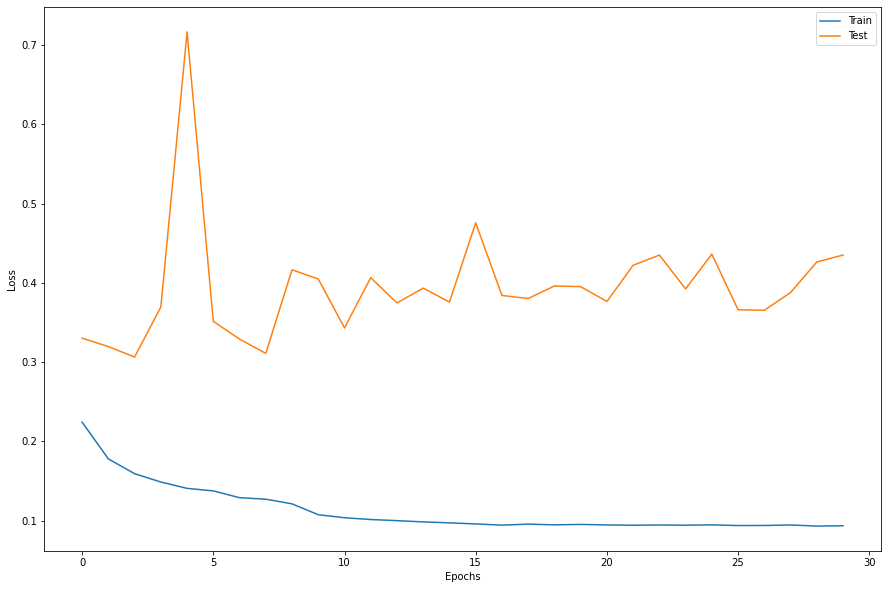

In [15]:
plt.figure(figsize=(15,10))
plt.plot(range(0,30),train_loss_hist, label = 'Train')
plt.plot(range(0,30),test_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'AUC')

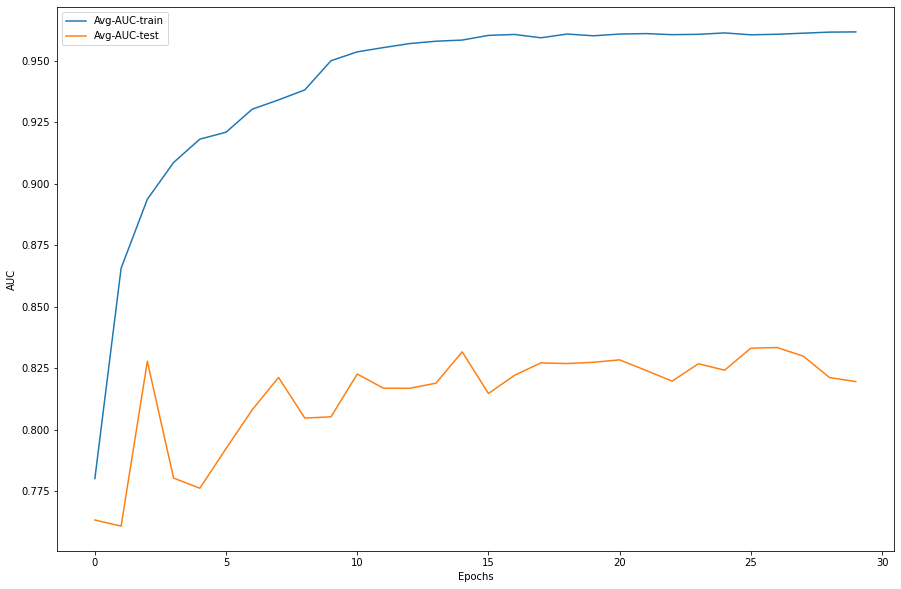

In [25]:
plt.figure(figsize=(15,10))
plt.plot(np.mean(train_AUC_hist, axis=1), label = 'Avg-AUC-train')
plt.plot(np.mean(test_AUC_hist, axis=1), label = 'Avg-AUC-test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("AUC")

Text(0, 0.5, 'Train-AUC')

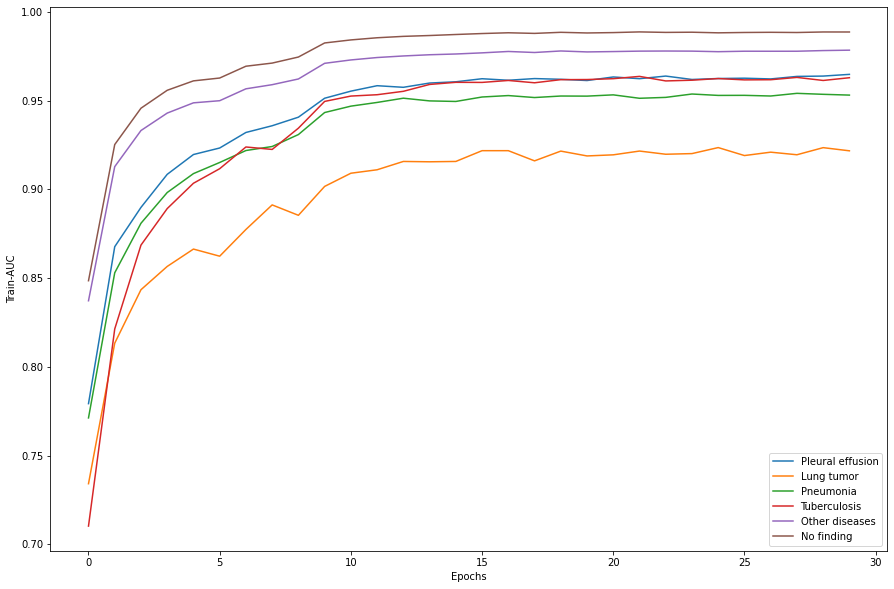

In [33]:
#train
global_labels = ['Pleural effusion', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
plt.figure(figsize=(15,10))
for i,j in enumerate(global_labels):
    plt.plot(train_AUC_hist[:,i], label = j)
    plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Train-AUC')

Text(0, 0.5, 'Test-AUC')

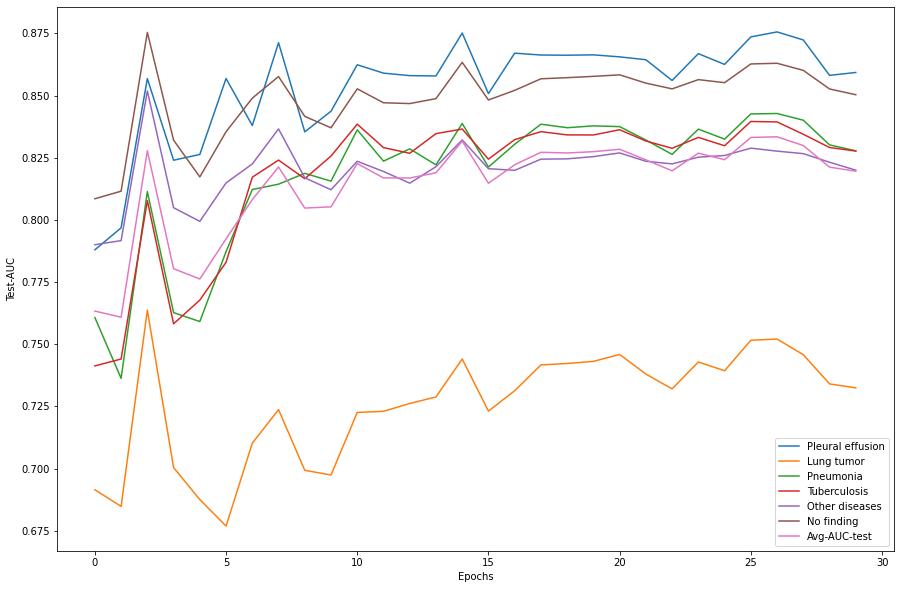

In [37]:
plt.figure(figsize=(15,10))
for i,j in enumerate(global_labels):
    plt.plot(test_AUC_hist[:,i], label = j)
plt.plot(np.mean(test_AUC_hist, axis=1), label = 'Avg-AUC-test')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Test-AUC')

In [59]:
model.load_state_dict(torch.load("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/DenseNet201_best_AUC.pt", map_location='cpu')['model_state_dict'])

<All keys matched successfully>

In [75]:
model.eval()
predicted = []
for images,labels in tqdm(testloader):
    ps = model(images)
    predicted.extend(ps.tolist())

In [85]:
np.array(testloader.dataset.labels)[:,0]

array([0, 0, 0, ..., 0, 0, 0])

In [84]:
from sklearn.metrics import roc_curve

In [87]:
fpr, tpr, thresholds =  roc_curve(np.array(testloader.dataset.labels)[:,0], np.array(predicted)[:,0])

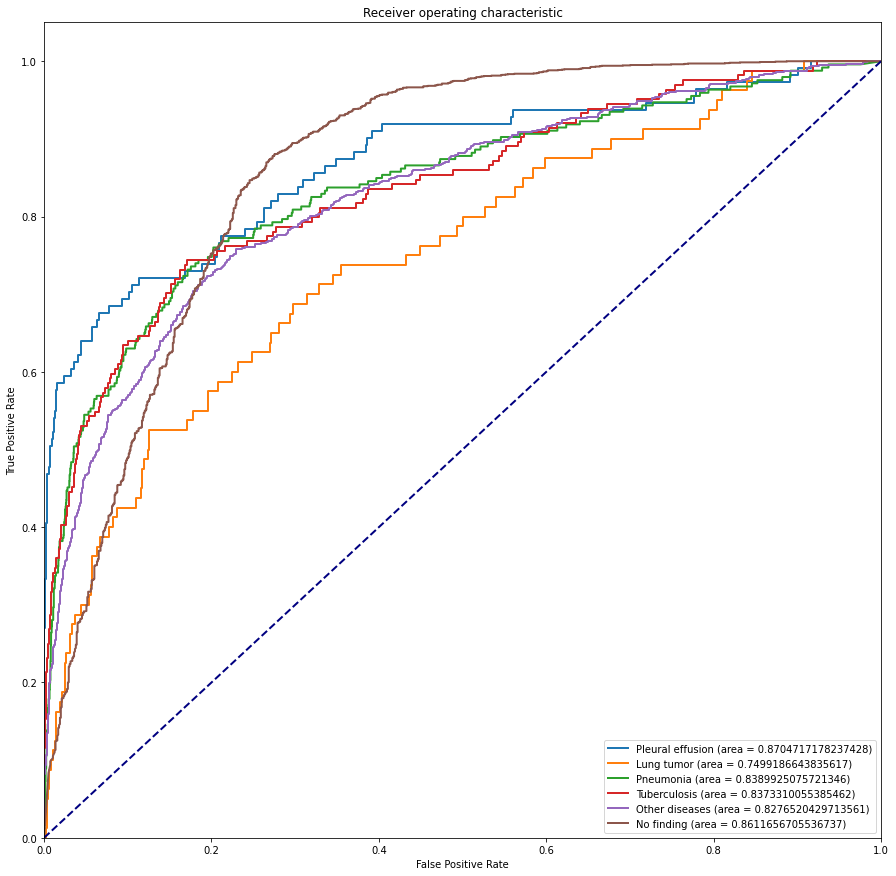

In [102]:
plt.figure(figsize=(15,15))
lw = 2
for i,j in enumerate(global_labels):
    fpr, tpr, thresholds =  roc_curve(np.array(testloader.dataset.labels)[:,i], np.array(predicted)[:,i])
    plt.plot(fpr,tpr,lw=lw,label=f"{global_labels[i]} (area = {auc(fpr,tpr)})")
    
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()


In [92]:
auc(fpr,tpr)

0.8704717178237428